In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import dask.dataframe as dd
import pandas as pd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!git clone https://github.com/iupui-soic/handson-ml-mimic-iv.git

Cloning into 'handson-ml-mimic-iv'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 83 (delta 29), reused 40 (delta 13), pack-reused 0
Receiving objects: 100% (83/83), 3.86 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
%cd handson-ml-mimic-iv

/content/handson-ml-mimic-iv


In [ ]:
!cp /content/drive/MyDrive/Mimic.py .



In [ ]:
from Mimic import MIMIC, MIMICManipulations

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
admissions_path = '/content/drive/MyDrive/mimiv-iv/mimiv-iv/admissions.parquet'
patients_path = '/content/drive/MyDrive/mimiv-iv/mimiv-iv/patients.parquet'
admissions_df = pd.read_parquet(admissions_path)
patients_df = pd.read_parquet(patients_path)
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df['los_admission'] = (admissions_df['dischtime'] - admissions_df['admittime']).dt.total_seconds() / (24 * 3600)
merged_df = admissions_df.merge(patients_df, on='subject_id', how='inner')
print("Columns in the merged DataFrame:")
print(merged_df.columns)
final_csv_path = '/content/drive/MyDrive/mimiv-iv/mimiv-iv/final_dataset.csv'
merged_df.to_csv(final_csv_path, index=False)
print(f"The final dataset has been saved to {final_csv_path}")

Columns in the merged DataFrame:
Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'los_admission',
       'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod'],
      dtype='object')
The final dataset has been saved to /content/drive/MyDrive/mimiv-iv/mimiv-iv/final_dataset.csv


#correlation heat map

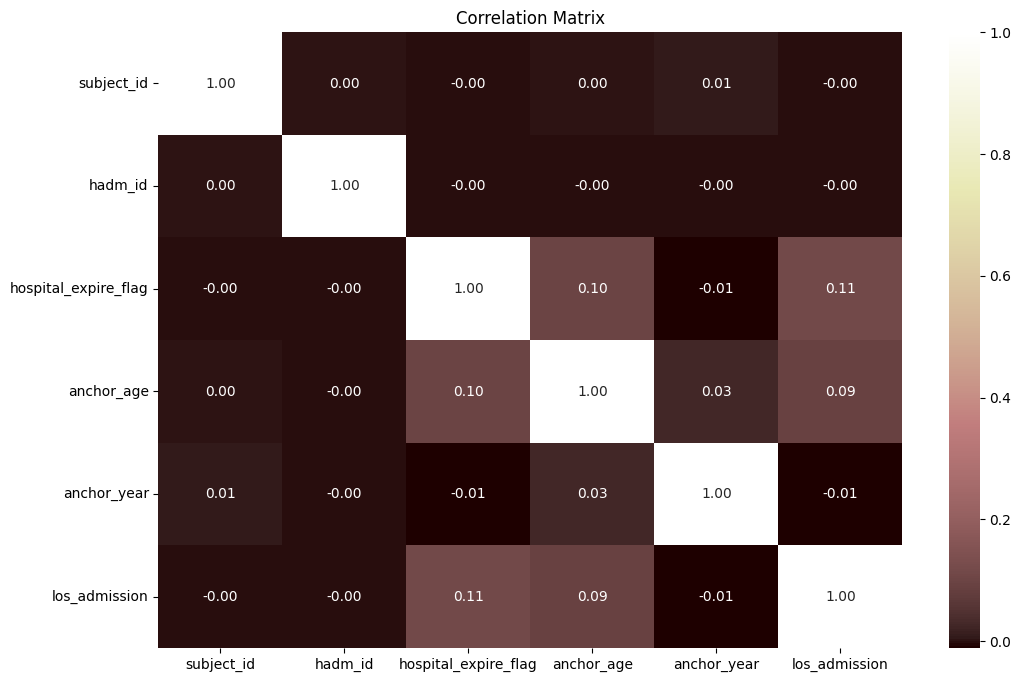

los_admission           1.000000
hospital_expire_flag    0.113004
anchor_age              0.088833
hadm_id                -0.000572
subject_id             -0.000967
anchor_year            -0.011465
Name: los_admission, dtype: float64


In [ ]:

if 'los_admission' not in df.columns:
    df['los_admission'] = (df['dischtime'] - df['admittime']).dt.total_seconds() / (24 * 3600)
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])
df_numeric = df.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='pink')
plt.title('Correlation Matrix')
plt.show()
corr_with_los = corr_matrix['los_admission'].sort_values(ascending=False)
print(corr_with_los)


Since hospital_expire_flag and anchor_age have the highest correlations with los_admission, we will use these features for our regression models.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
final_csv_path = '/content/drive/MyDrive/mimiv-iv/mimiv-iv/final_dataset.csv'
merged_df = pd.read_csv(final_csv_path)
final_df = merged_df[['los_admission', 'anchor_age', 'hospital_expire_flag']]
X = final_df[['los_admission', 'anchor_age']]
y = final_df['hospital_expire_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Linear regression

Linear Regression:
Train MSE: 0.01906197478310102
Test MSE: 0.019402155260112654
Train R2: 0.02122067847152187
Test R2: 0.018858929424812154


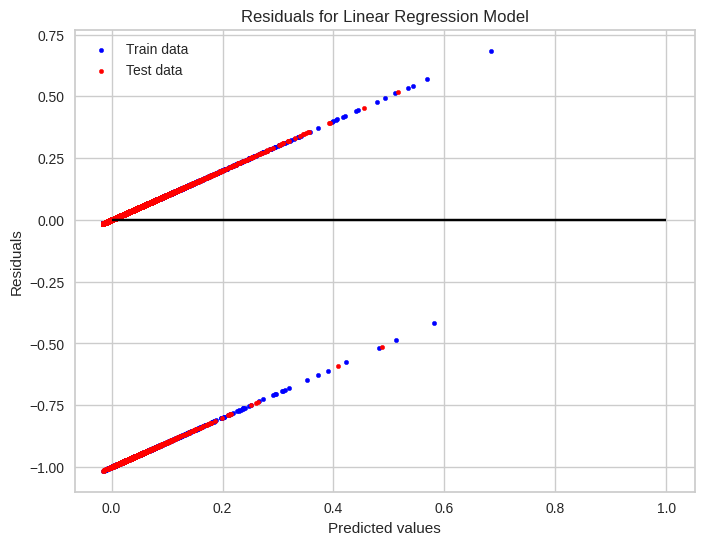

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_train_pred = lin_reg.predict(X_train_scaled)
y_test_pred = lin_reg.predict(X_test_scaled)

print("Linear Regression:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, color="blue", s=10, label="Train data")
plt.scatter(y_test_pred, y_test_pred - y_test, color="red", s=10, label="Test data")
plt.hlines(y=0, xmin=0, xmax=1, color="black")
plt.title("Residuals for Linear Regression Model")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.show()


Ridge regression


Ridge Regression:
Train MSE: 0.019061974783104875
Test MSE: 0.019402155148976773
Train R2: 0.021220678471323917
Test R2: 0.01885893504480518


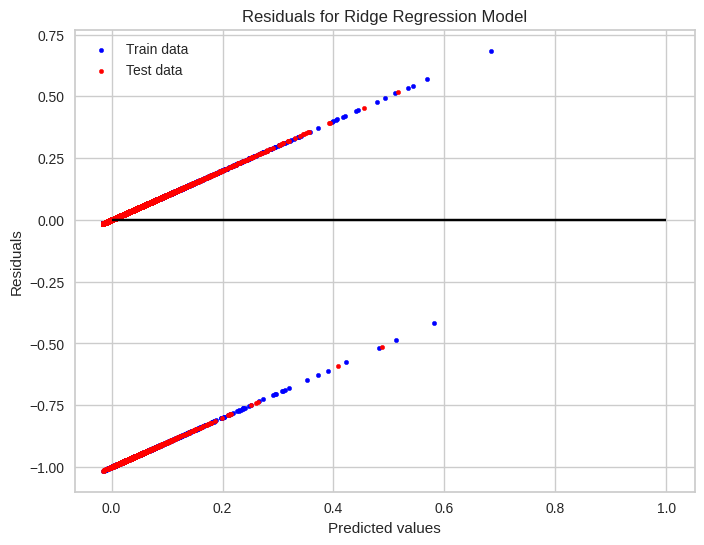

In [ ]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)

y_train_pred = ridge_reg.predict(X_train_scaled)
y_test_pred = ridge_reg.predict(X_test_scaled)

print("\nRidge Regression:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))



plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, color="blue", s=10, label="Train data")
plt.scatter(y_test_pred, y_test_pred - y_test, color="red", s=10, label="Test data")
plt.hlines(y=0, xmin=0, xmax=1, color="black")
plt.title("Residuals for Ridge Regression Model")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.show()



Lasso regression


Lasso Regression:
Train MSE: 0.01947525286224225
Test MSE: 0.019775189893182256
Train R2: 0.0
Test R2: -4.933601990941838e-06


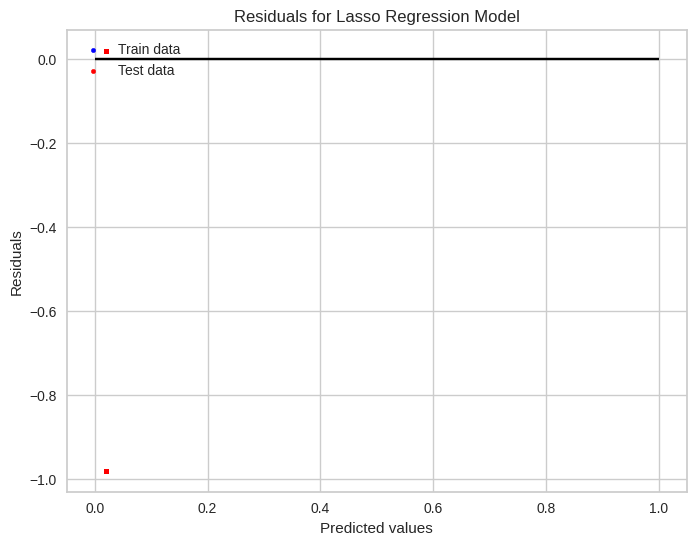

In [ ]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

y_train_pred = lasso_reg.predict(X_train_scaled)
y_test_pred = lasso_reg.predict(X_test_scaled)

print("\nLasso Regression:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, color="blue", s=10, label="Train data")
plt.scatter(y_test_pred, y_test_pred - y_test, color="red", s=10, label="Test data")
plt.hlines(y=0, xmin=0, xmax=1, color="black")
plt.title("Residuals for Lasso Regression Model")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.show()


Elastic net regression


Elastic Net Regression:
Train MSE: 0.01947525286224225
Test MSE: 0.019775189893182256
Train R2: 0.0
Test R2: -4.933601990941838e-06


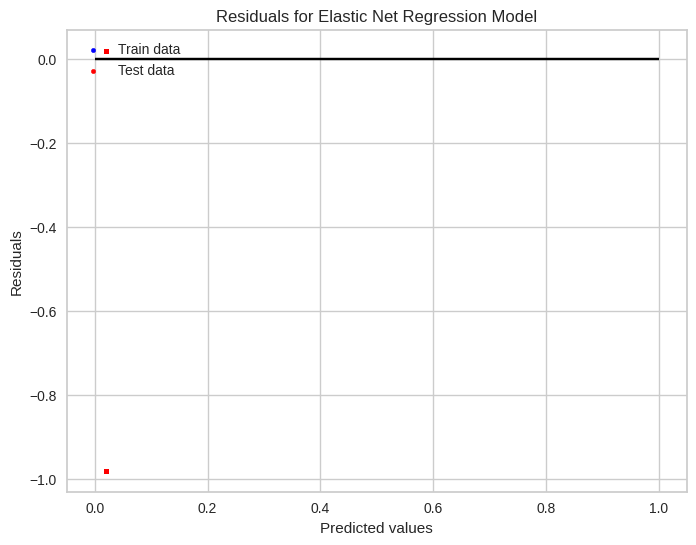

In [ ]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_scaled, y_train)

y_train_pred = elastic_net.predict(X_train_scaled)
y_test_pred = elastic_net.predict(X_test_scaled)

print("\nElastic Net Regression:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, color="blue", s=10, label="Train data")
plt.scatter(y_test_pred, y_test_pred - y_test, color="red", s=10, label="Test data")
plt.hlines(y=0, xmin=0, xmax=1, color="black")
plt.title("Residuals for Elastic Net Regression Model")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.show()


SDE Regression


SGD Regressor:
Train MSE: 0.0190634287686399
Test MSE: 0.019401509851499174
Train R2: 0.021146020363143947
Test R2: 0.018891566876141574


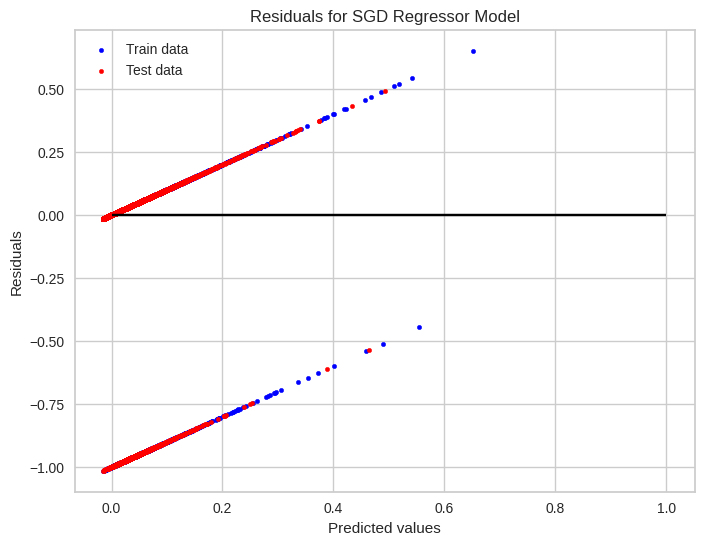

In [ ]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, random_state=42)
sgd_reg.fit(X_train_scaled, y_train)

y_train_pred = sgd_reg.predict(X_train_scaled)
y_test_pred = sgd_reg.predict(X_test_scaled)

print("\nSGD Regressor:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))


plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, color="blue", s=10, label="Train data")
plt.scatter(y_test_pred, y_test_pred - y_test, color="red", s=10, label="Test data")
plt.hlines(y=0, xmin=0, xmax=1, color="black")
plt.title("Residuals for SGD Regressor Model")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.show()



Model Performance Comparison:
                   Train MSE  Test MSE  Train R2   Test R2
Linear Regression   0.019062  0.019402  0.021221  0.018859
Ridge Regression    0.019062  0.019402  0.021221  0.018859
Lasso Regression    0.019475  0.019775  0.000000 -0.000005
Elastic Net         0.019475  0.019775  0.000000 -0.000005
SGD Regressor       0.019063  0.019402  0.021146  0.018892


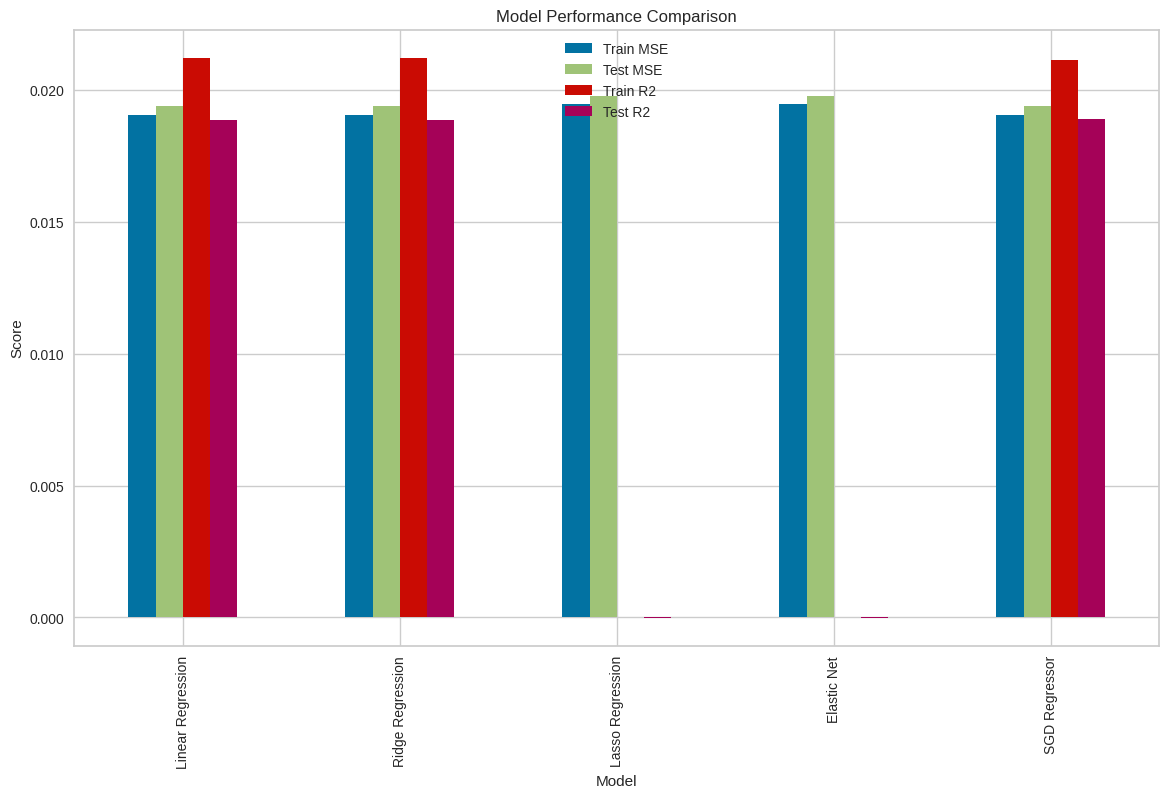

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

final_df = merged_df[['los_admission', 'anchor_age', 'hospital_expire_flag']]


X = final_df[['los_admission', 'anchor_age']]
y = final_df['hospital_expire_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'SGD Regressor': SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, random_state=42)
}


model_performance = {}


def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    model_performance[name] = {
        'Train MSE': mse_train,
        'Test MSE': mse_test,
        'Train R2': r2_train,
        'Test R2': r2_test
    }

# Evaluate each model
for name, model in models.items():
    evaluate_model(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

# Compare model performance
performance_df = pd.DataFrame(model_performance).T
print("\nModel Performance Comparison:")
print(performance_df)

# Visualize model performance
performance_df[['Train MSE', 'Test MSE', 'Train R2', 'Test R2']].plot(kind='bar', figsize=(14, 8))
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.grid(True)
plt.show()


<!DOCTYPE html>
<html>
<head>
     <title>Model Performance Comparison</title>
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
        }
        table, th, td {
            border: 1px solid black;
        }
        th, td {
            padding: 8px;
            text-align: center;
        }
        th {
            background-color: #f2f2f2;
        }
        .section-title {
            font-size: 1.5em;
            font-weight: bold;
            margin-top: 20px;
        }
        .interpretation {
            margin-top: 20px;
        }
    </style>
</head>
<body>
              <title>Model Performance Comparison</title>
    <table>
        <thead>
            <tr>
                <th>Model</th>
                <th>Train MSE</th>
                <th>Test MSE</th>
                <th>Train R²</th>
                <th>Test R²</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Linear Regression</td>
                <td>0.019062</td>
                <td>0.019402</td>
                <td>0.021221</td>
                <td>0.018859</td>
            </tr>
            <tr>
                <td>Ridge Regression</td>
                <td>0.019062</td>
                <td>0.019402</td>
                <td>0.021221</td>
                <td>0.018859</td>
            </tr>
            <tr>
                <td>Lasso Regression</td>
                <td>0.019475</td>
                <td>0.019775</td>
                <td>0.000000</td>
                <td>-0.000005</td>
            </tr>
            <tr>
                <td>Elastic Net</td>
                <td>0.019475</td>
                <td>0.019775</td>
                <td>0.000000</td>
                <td>-0.000005</td>
            </tr>
            <tr>
                <td>SGD Regressor</td>
                <td>0.019063</td>
                <td>0.019402</td>
                <td>0.021146</td>
                <td>0.018892</td>
            </tr>
        </tbody>
    </table>

   
       ** Best Performing Models:**The models with the lowest MSE and highest R² values are Linear Regression, Ridge Regression, and SGD Regressor. These models show similar performance, indicating they fit the data well and are likely to provide reliable predictions.</p>
        **Poor Performing Models:**Lasso Regression and Elastic Net show poor performance with zero or negative R² values. This indicates that these models did not fit the data well and may not be suitable for this task.
        **Consistency:**Linear Regression, Ridge Regression, and SGD Regressor are consistent in their performance across both training and test datasets. This suggests that these models generalize well and are reliable for this task.
    
</body>
</html>


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


try:
    final_df = pd.read_csv('/content/drive/MyDrive/mimiv-iv/mimiv-iv/final_dataset.csv')
    # Convert relevant columns to appropriate data types
    final_df['hospital_expire_flag'] = final_df['hospital_expire_flag'].astype(float)
    final_df['anchor_age'] = final_df['anchor_age'].astype(float)
    final_df['los_admission'] = final_df['los_admission'].astype(float)
except Exception as e:
    print(f"Error loading CSV file: {e}")
    final_df = None


required_columns = ['hospital_expire_flag', 'los_admission', 'anchor_age']
if final_df is not None and all(column in final_df.columns for column in required_columns):
    # Define the target and features
    y = final_df['hospital_expire_flag'].values  # Target variable
    X = final_df[['los_admission', 'anchor_age']]  # Only use los_admission and anchor_age as features

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Define the logistic regression model
    log_reg = LogisticRegression(random_state=42, max_iter=1000)

    # Define the hyperparameters grid
    param_grid = {
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Print the best parameters found by GridSearchCV
    print("Best Parameters:", grid_search.best_params_)

    # Train the model with the best parameters
    best_log_reg = grid_search.best_estimator_

    # Make predictions on the test set
    y_test_preds = best_log_reg.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_test_preds)
    conf_matrix = confusion_matrix(y_test, y_test_preds)
    class_report = classification_report(y_test, y_test_preds)

    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
else:
    print("Error: The required columns are not present in the dataset or the dataset failed to load.")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.001, 'solver': 'liblinear'}
Accuracy: 0.979442763226547
Confusion Matrix:
[[84472    19]
 [ 1754     2]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     84491
         1.0       0.10      0.00      0.00      1756

    accuracy                           0.98     86247
   macro avg       0.54      0.50      0.50     86247
weighted avg       0.96      0.98      0.97     86247



In [ ]:
pip install imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE



# Convert relevant columns to appropriate data types
final_df['hospital_expire_flag'] = final_df['hospital_expire_flag'].astype(float)
final_df['anchor_age'] = final_df['anchor_age'].astype(float)
final_df['los_admission'] = final_df['los_admission'].astype(float)

# Define the target and features
y = final_df['hospital_expire_flag'].values  # Target variable
X = final_df[['los_admission', 'anchor_age']]  # Only use los_admission and anchor_age as features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Logistic Regression with class weight adjustment
log_reg = LogisticRegression(solver="liblinear", random_state=42)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_log_reg = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_log_reg.fit(X_train_smote, y_train_smote)

best_log_reg = grid_search_log_reg.best_estimator_
y_pred = best_log_reg.predict(X_test)

print("Best Parameters:", grid_search_log_reg.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 0.001}
Accuracy: 0.6713276983547254
Confusion Matrix:
 [[56647 27844]
 [  503  1253]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.67      0.80     84491
         1.0       0.04      0.71      0.08      1756

    accuracy                           0.67     86247
   macro avg       0.52      0.69      0.44     86247
weighted avg       0.97      0.67      0.79     86247



In [ ]:
pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 62.7 MB/s eta 0:00:00
   ━━━

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import pycaret
pycaret.__version__

'3.3.2'

,Description,Value
0,Session id,123
1,Target,hospital_expire_flag
2,Target type,Regression
3,Original data shape,"(431231, 3)"
4,Transformed data shape,"(431231, 3)"
5,Transformed train set shape,"(301861, 3)"
6,Transformed test set shape,"(129370, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.8620
ridge,Ridge Regression,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.0640
lar,Least Angle Regression,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.0650
br,Bayesian Ridge,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.0800
omp,Orthogonal Matching Pursuit,0.0399,0.0195,0.1397,0.0097,0.0971,0.9704,0.0650
lasso,Lasso Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.0660
en,Elastic Net,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.0650
llar,Lasso Least Angle Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.0630
huber,Huber Regressor,0.0201,0.0201,0.1418,-0.0205,0.0983,1.0000,3.6070
knn,K Neighbors Regressor,0.0376,0.0227,0.1505,-0.1494,0.1098,0.9441,0.8160


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

,Description,Value
0,Session id,123
1,Target,hospital_expire_flag
2,Target type,Regression
3,Original data shape,"(431231, 3)"
4,Transformed data shape,"(431231, 3)"
5,Transformed train set shape,"(301861, 3)"
6,Transformed test set shape,"(129370, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.0700
ridge,Ridge Regression,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.0610
lar,Least Angle Regression,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.0630
br,Bayesian Ridge,0.0403,0.0193,0.1389,0.0208,0.0966,0.9595,0.0680
omp,Orthogonal Matching Pursuit,0.0399,0.0195,0.1397,0.0097,0.0971,0.9704,0.0600
lasso,Lasso Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.0660
en,Elastic Net,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.0660
llar,Lasso Least Angle Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.0620
huber,Huber Regressor,0.0201,0.0201,0.1418,-0.0205,0.0983,1.0000,3.5320
knn,K Neighbors Regressor,0.0376,0.0227,0.1505,-0.1494,0.1098,0.9441,0.7280


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

LinearRegression(n_jobs=-1)
LinearRegression(n_jobs=-1)


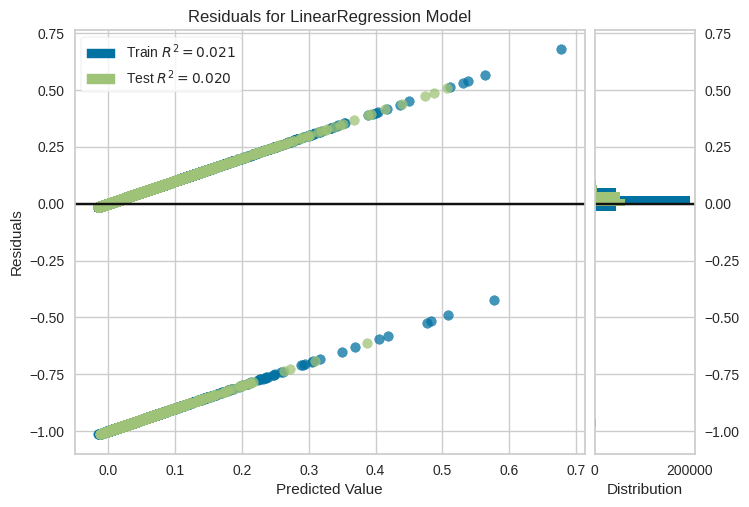

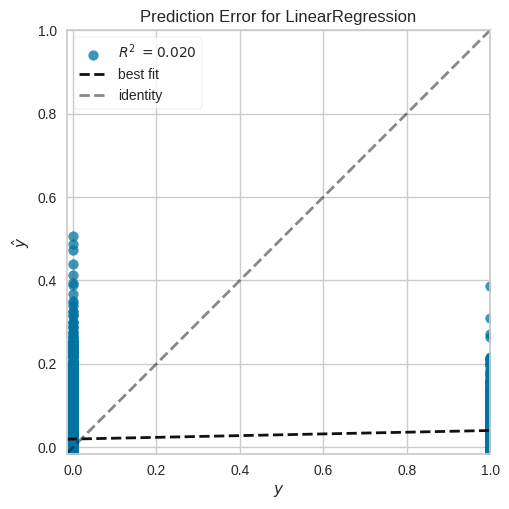

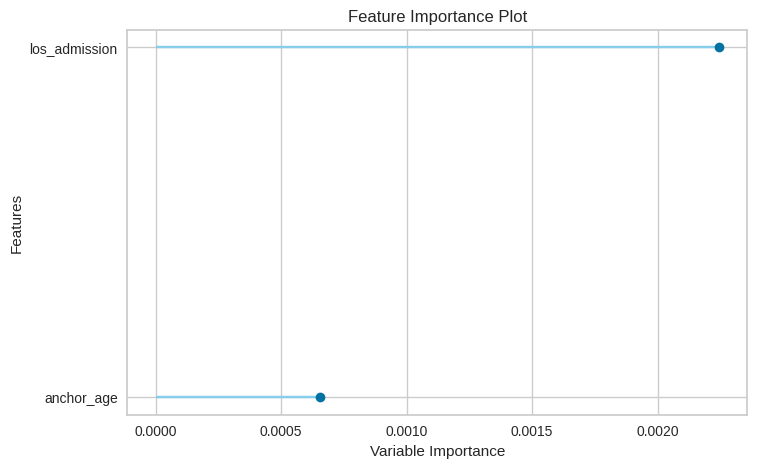

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
import pandas as pd

# Load the final merged dataset
final_csv_path = '/content/drive/MyDrive/mimiv-iv/mimiv-iv/final_dataset.csv'
merged_df = pd.read_csv(final_csv_path)


final_df = merged_df[['los_admission', 'anchor_age', 'hospital_expire_flag']]

# Import PyCaret's regression module
from pycaret.regression import *

# Initialize the setup for your data
s = setup(data=final_df, target='hospital_expire_flag', session_id=123, use_gpu=False)

# List of less resource-intensive models
selected_models = [
    'lr', 'ridge', 'lar', 'br', 'omp', 'lasso', 'en', 'llar', 'huber', 'knn', 'par', 'dt'
]

# Compare baseline models using only selected models
best_model = compare_models(include=selected_models)


from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()

# Initialize the setup on the experiment
exp.setup(data=final_df, target='hospital_expire_flag', session_id=123, use_gpu=False)

# Compare baseline models using only selected models
best_model_exp = exp.compare_models(include=selected_models)

# Print the best model
print(best_model)
print(best_model_exp)

# Analyze the model
# Plot residuals
plot_model(best_model, plot='residuals')

# Plot error
plot_model(best_model, plot='error')

# Plot feature importance
plot_model(best_model, plot='feature')


evaluate_model(best_model)


<ul>
  <li><b>Best Performing Models:</b>
    <ul>
      <li>Linear Regression</li>
      <li>Ridge Regression</li>
      <li>Least Angle Regression</li>
      <li>Bayesian Ridge</li>
      <li>These models have the lowest MAE, MSE, RMSE, and highest R² values.</li>
    </ul>
  </li>
  <li><b>Poor Performing Models:</b>
    <ul>
      <li>Lasso Regression</li>
      <li>Elastic Net</li>
      <li>Huber Regressor</li>
      <li>K Neighbors Regressor</li>
      <li>Passive Aggressive Regressor</li>
      <li>Decision Tree Regressor</li>
      <li>These models have negative R² values, indicating poor fits.</li>
    </ul>
  </li>
  <li><b>Model Accuracy:</b>
    <ul>
      <li>The low R² values indicate the model isn't very good at predicting the target variable.</li>
    </ul>
  </li>
  <li><b>Identity Line (dashed grey line):</b>
    <ul>
      <li>Represents the ideal scenario where predictions are perfect. If a point lies on this line, it means the predicted value exactly matches the actual value.</li>
    </ul>
  </li>
  <li><b>Best Fit Line (dashed black line):</b>
    <ul>
      <li>Represents the best fit through the data points (actual vs. predicted values). Shows the overall trend of the predictions made by the model.</li>
    </ul>
  </li>
  <li><b>Poor Model Performance:</b>
    <ul>
      <li>The low R² value and the distribution of points suggest that the linear regression model is not performing well on this dataset.</li>
    </ul>
  </li>
</ul>


#statistical analysis :

los_admission_binned  Very Short Stay  Short Stay  Medium Stay  Long Stay
gender                                                                   
F                               49254       74468        67363      33839
M                               50634       61228        56878      37428
Very Short Stay - Female: 49254, Male: 50634
Short Stay - Female: 74468, Male: 61228
Medium Stay - Female: 67363, Male: 56878
Long Stay - Female: 33839, Male: 37428


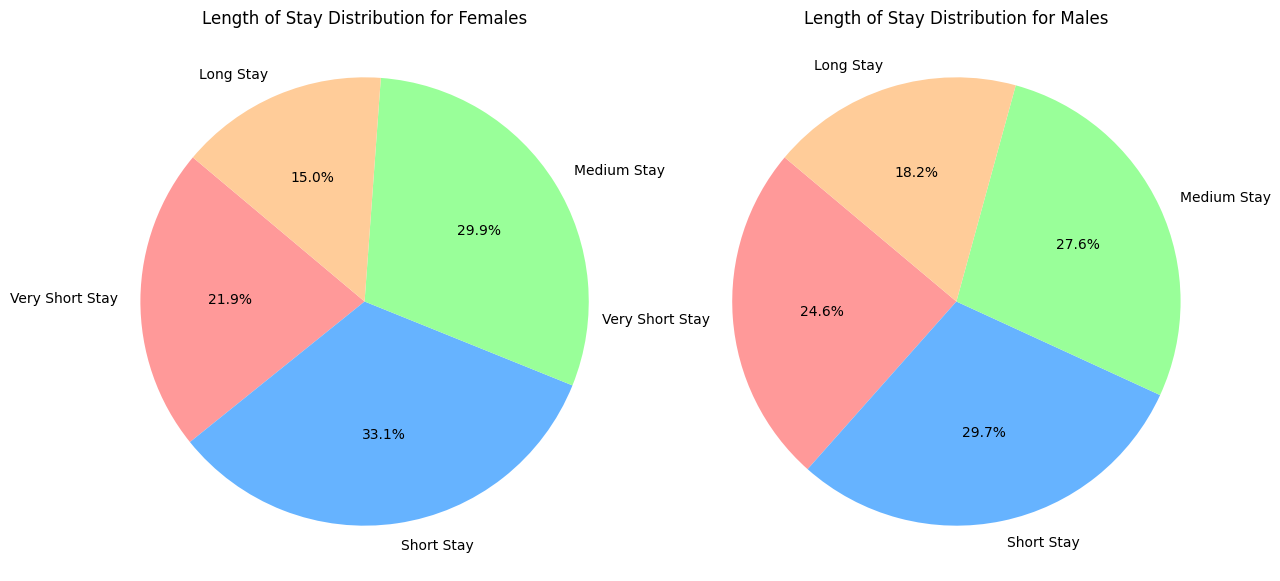

In [ ]:
from google.colab import drive
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt


df_patients = pd.read_parquet(patients_path)
df_admissions = pd.read_parquet(admissions_path)


merged_df = pd.merge(df_patients, df_admissions, on='subject_id', how='inner')


merged_df['admittime'] = pd.to_datetime(merged_df['admittime'])
merged_df['dischtime'] = pd.to_datetime(merged_df['dischtime'])
merged_df['los_admission'] = (merged_df['dischtime'] - merged_df['admittime']).dt.total_seconds() / (24 * 3600)


bins = [0, 1, 3, 7, merged_df['los_admission'].max()]
labels = ['Very Short Stay', 'Short Stay', 'Medium Stay', 'Long Stay']
merged_df['los_admission_binned'] = pd.cut(merged_df['los_admission'], bins=bins, labels=labels, include_lowest=True)


contingency_table = pd.crosstab(merged_df['gender'], merged_df['los_admission_binned'])
print(contingency_table)
very_short_stay_female = contingency_table.loc['F', 'Very Short Stay']
very_short_stay_male = contingency_table.loc['M', 'Very Short Stay']
short_stay_female = contingency_table.loc['F', 'Short Stay']
short_stay_male = contingency_table.loc['M', 'Short Stay']
medium_stay_female = contingency_table.loc['F', 'Medium Stay']
medium_stay_male = contingency_table.loc['M', 'Medium Stay']
long_stay_female = contingency_table.loc['F', 'Long Stay']
long_stay_male = contingency_table.loc['M', 'Long Stay']


print(f"Very Short Stay - Female: {very_short_stay_female}, Male: {very_short_stay_male}")
print(f"Short Stay - Female: {short_stay_female}, Male: {short_stay_male}")
print(f"Medium Stay - Female: {medium_stay_female}, Male: {medium_stay_male}")
print(f"Long Stay - Female: {long_stay_female}, Male: {long_stay_male}")

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Female pie chart
sizes_female = [very_short_stay_female, short_stay_female, medium_stay_female, long_stay_female]
axes[0].pie(sizes_female, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title('Length of Stay Distribution for Females')

# Male pie chart
sizes_male = [very_short_stay_male, short_stay_male, medium_stay_male, long_stay_male]
axes[1].pie(sizes_male, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].set_title('Length of Stay Distribution for Males')

plt.show()


los_admission = 0.5 -> Very Short Stay
los_admission = 2 -> Short Stay
los_admission = 5 -> Medium Stay
los_admission = 10 -> Long Stay

The independent t-test results show a statistically significant difference in the mean length of stay between males and females, with females having a shorter length of stay on average compared to males.

In [ ]:
# Step 5: Perform the t-test
los_female = merged_df[merged_df['gender'] == 'F']['los_admission']
los_male = merged_df[merged_df['gender'] == 'M']['los_admission']

t_stat, p_value = ttest_ind(los_female, los_male)

# Step 6: Print the results and significance
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The result is statistically significant.")
else:
    print("The result is not statistically significant.")

T-statistic: -19.201930736722325
P-value: 3.859767003188429e-82
The result is statistically significant.


A large absolute value of the T-statistic indicates a significant difference between the groups.

Performance Metrics
MAE (Mean Absolute Error)
MSE (Mean Squared Error)
RMSE (Root Mean Squared Error)
R2 (R-squared)
RMSLE (Root Mean Squared Logarithmic Error)
MAPE (Mean Absolute Percentage Error)

,Description,Value
0,Session id,123
1,Target,hospital_expire_flag
2,Target type,Regression
3,Original data shape,"(431231, 5)"
4,Transformed data shape,"(431231, 5)"
5,Transformed train set shape,"(301861, 5)"
6,Transformed test set shape,"(129370, 5)"
7,Numeric features,2
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0407,0.0191,0.1381,0.0320,0.0962,0.9483,1.4060
ridge,Ridge Regression,0.0406,0.0191,0.1381,0.0320,0.0961,0.9485,0.5500
lar,Least Angle Regression,0.0407,0.0191,0.1381,0.0320,0.0962,0.9483,0.6260
br,Bayesian Ridge,0.0407,0.0191,0.1381,0.0320,0.0962,0.9483,0.7610
omp,Orthogonal Matching Pursuit,0.0399,0.0195,0.1397,0.0097,0.0971,0.9704,0.5490
lasso,Lasso Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.8650
en,Elastic Net,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.5500
llar,Lasso Least Angle Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.7240
huber,Huber Regressor,0.0201,0.0201,0.1418,-0.0205,0.0983,1.0000,3.3290
knn,K Neighbors Regressor,0.0361,0.0223,0.1494,-0.1320,0.1085,0.9448,1.3270


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

,Description,Value
0,Session id,123
1,Target,hospital_expire_flag
2,Target type,Regression
3,Original data shape,"(431231, 5)"
4,Transformed data shape,"(431231, 5)"
5,Transformed train set shape,"(301861, 5)"
6,Transformed test set shape,"(129370, 5)"
7,Numeric features,2
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0407,0.0191,0.1381,0.0320,0.0962,0.9483,0.8910
ridge,Ridge Regression,0.0406,0.0191,0.1381,0.0320,0.0961,0.9485,0.5560
lar,Least Angle Regression,0.0407,0.0191,0.1381,0.0320,0.0962,0.9483,0.7300
br,Bayesian Ridge,0.0407,0.0191,0.1381,0.0320,0.0962,0.9483,0.6420
omp,Orthogonal Matching Pursuit,0.0399,0.0195,0.1397,0.0097,0.0971,0.9704,0.5810
lasso,Lasso Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.9070
en,Elastic Net,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.7930
llar,Lasso Least Angle Regression,0.0394,0.0197,0.1404,-0.0000,0.0975,0.9799,0.8090
huber,Huber Regressor,0.0201,0.0201,0.1418,-0.0205,0.0983,1.0000,3.3930
knn,K Neighbors Regressor,0.0361,0.0223,0.1494,-0.1320,0.1085,0.9448,1.4610


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

LinearRegression(n_jobs=-1)
LinearRegression(n_jobs=-1)


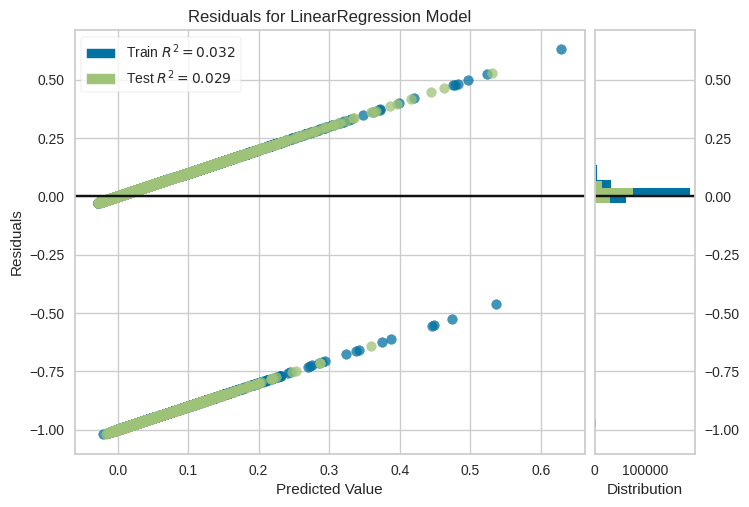

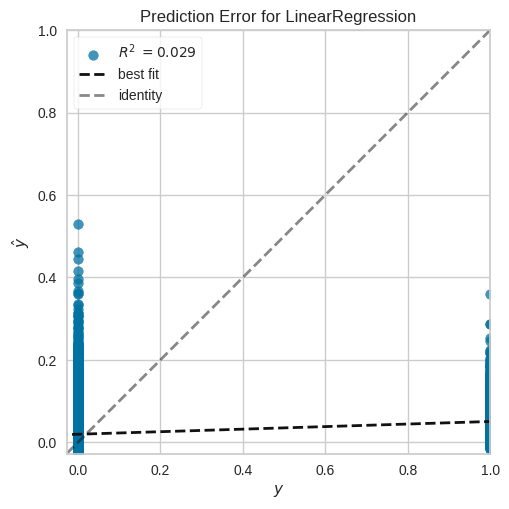

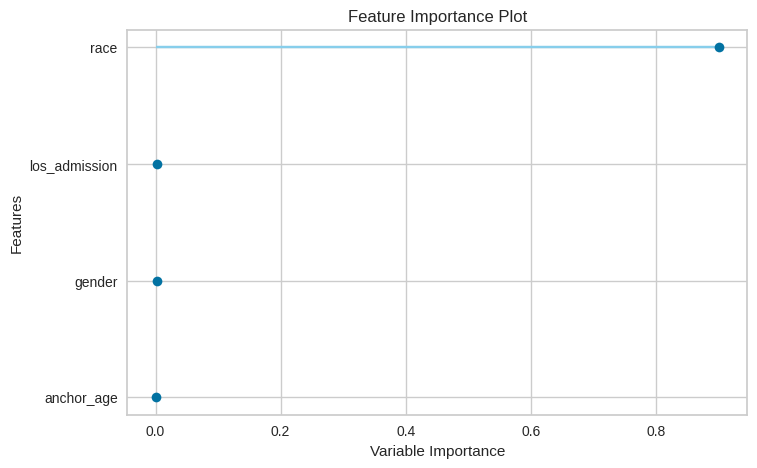

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
import pandas as pd

# Load the final merged dataset
final_csv_path = '/content/drive/MyDrive/mimiv-iv/mimiv-iv/final_dataset.csv'
merged_df = pd.read_csv(final_csv_path)

selected_features = ['race', 'gender', 'anchor_age', 'los_admission', 'hospital_expire_flag']

# Filter the DataFrame to include only the relevant columns
final_df = merged_df[selected_features]

# Import PyCaret's regression module
from pycaret.regression import *

# Initialize the setup for your data
s = setup(data=final_df, target='hospital_expire_flag', session_id=123, use_gpu=False)

# List of less resource-intensive models
selected_models = [
    'lr', 'ridge', 'lar', 'br', 'omp', 'lasso', 'en', 'llar', 'huber', 'knn', 'par', 'dt'
]

# Compare baseline models using only selected models
best_model = compare_models(include=selected_models)

from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()

# Initialize the setup on the experiment
exp.setup(data=final_df, target='hospital_expire_flag', session_id=123, use_gpu=False)

# Compare baseline models using only selected models
best_model_exp = exp.compare_models(include=selected_models)

# Print the best model
print(best_model)
print(best_model_exp)

# Analyze the model
# Plot residuals
plot_model(best_model, plot='residuals')

# Plot error
plot_model(best_model, plot='error')

# Plot feature importance
plot_model(best_model, plot='feature')

# Alternatively, evaluate the model
evaluate_model(best_model)


Linear Regression (lr)

 Slightly better RMSE (0.1381 vs. 0.1389) and R2 (0.0320 vs. 0.0208).
Ridge Regression (ridge)

 Better RMSE (0.1381 vs. 0.1389) and R2 (0.0320 vs. 0.0208).
Least Angle Regression (lar)

 Better RMSE (0.1381 vs. 0.1389) and R2 (0.0320 vs. 0.0208).
Bayesian Ridge (br)

 Better RMSE (0.1381 vs. 0.1389) and R2 (0.0320 vs. 0.0208).
K Neighbors Regressor (knn)

 Better MAE (0.0361 vs. 0.0376), MSE (0.0223 vs. 0.0227), RMSE (0.1494 vs. 0.1505), and R2 (-0.1320 vs. -0.1494).
Passive Aggressive Regressor (par)

 Better MAE (0.0675 vs. 0.0729), MSE (0.0234 vs. 0.0244), RMSE (0.1529 vs. 0.1561), and R2 (-0.1873 vs. -0.2361).
Decision Tree Regressor (dt)

 Slightly better MAE (0.0381 vs. 0.0387) and MAPE (0.9080 vs. 0.9358).

Training SVM with kernel='rbf' and C=1
Model accuracy with kernel='rbf' and C=1: 0.7436
Classification Report (Kernel=rbf, C=1):
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       196
           1       0.72      0.80      0.76       194

    accuracy                           0.74       390
   macro avg       0.75      0.74      0.74       390
weighted avg       0.75      0.74      0.74       390



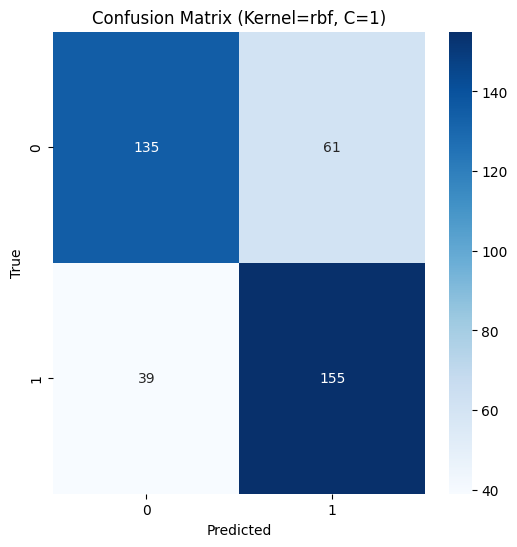

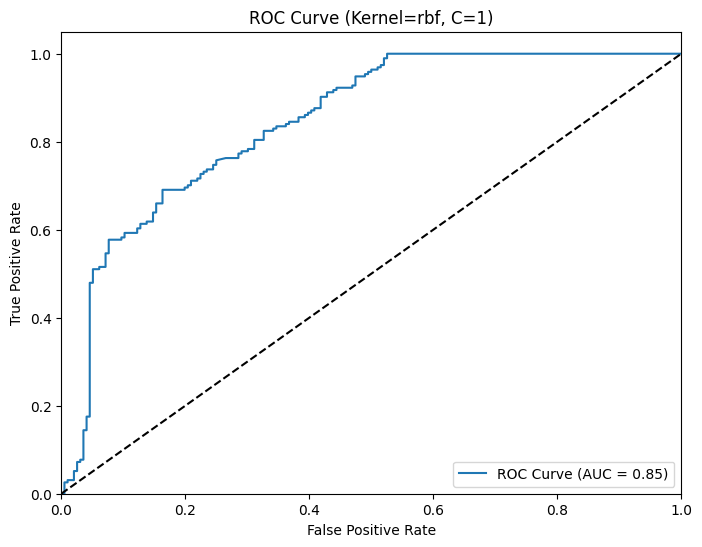

Training SVM with kernel='rbf' and C=100
Model accuracy with kernel='rbf' and C=100: 0.8231
Classification Report (Kernel=rbf, C=100):
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       196
           1       0.79      0.89      0.83       194

    accuracy                           0.82       390
   macro avg       0.83      0.82      0.82       390
weighted avg       0.83      0.82      0.82       390



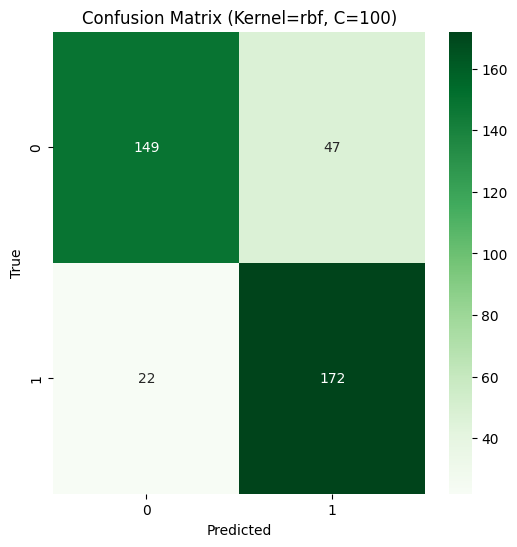

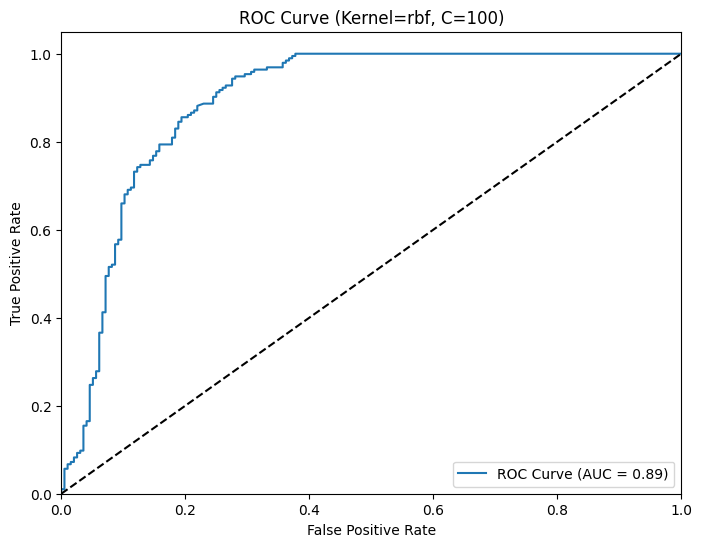

Training SVM with kernel='linear' and C=1
Model accuracy with kernel='linear' and C=1: 0.6718
Classification Report (Kernel=linear, C=1):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       196
           1       0.67      0.66      0.67       194

    accuracy                           0.67       390
   macro avg       0.67      0.67      0.67       390
weighted avg       0.67      0.67      0.67       390



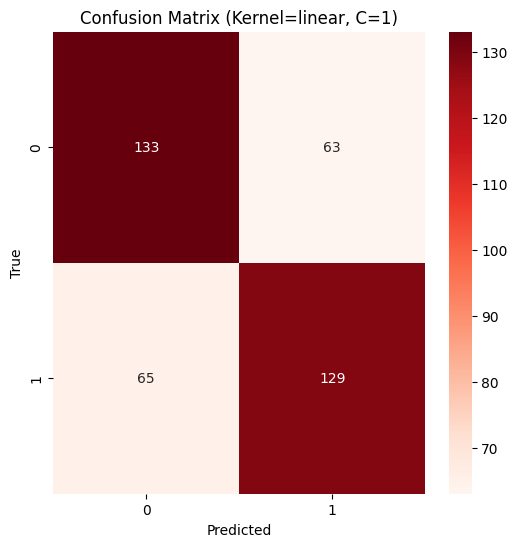

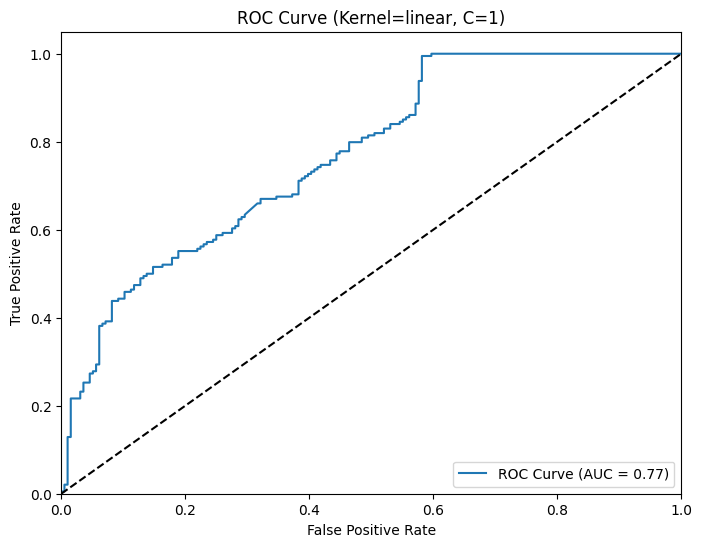

Training SVM with kernel='linear' and C=100
Model accuracy with kernel='linear' and C=100: 0.6718
Classification Report (Kernel=linear, C=100):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       196
           1       0.67      0.66      0.67       194

    accuracy                           0.67       390
   macro avg       0.67      0.67      0.67       390
weighted avg       0.67      0.67      0.67       390



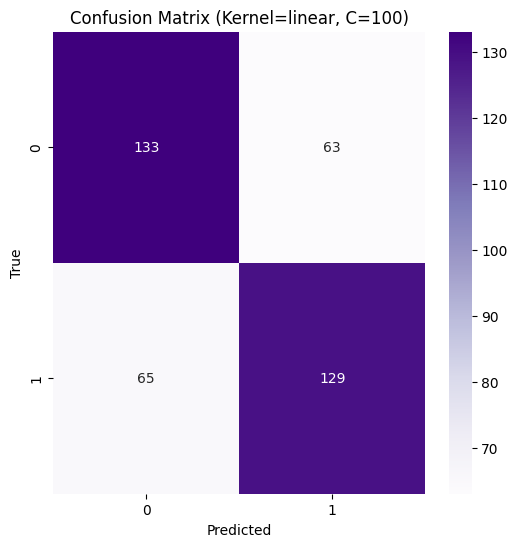

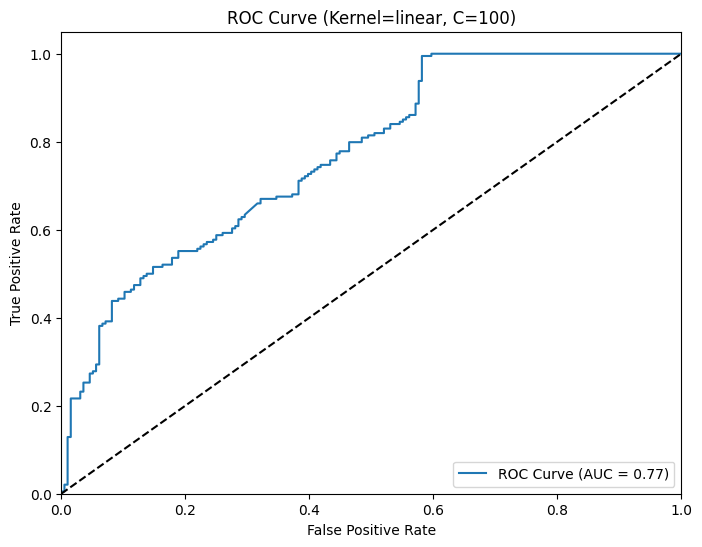

Training SVM with kernel='poly' and C=1
Model accuracy with kernel='poly' and C=1: 0.6410
Classification Report (Kernel=poly, C=1):
              precision    recall  f1-score   support

           0       0.61      0.81      0.69       196
           1       0.71      0.47      0.57       194

    accuracy                           0.64       390
   macro avg       0.66      0.64      0.63       390
weighted avg       0.66      0.64      0.63       390



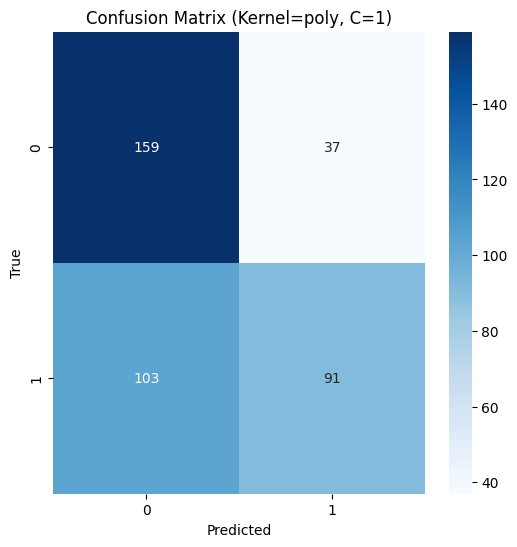

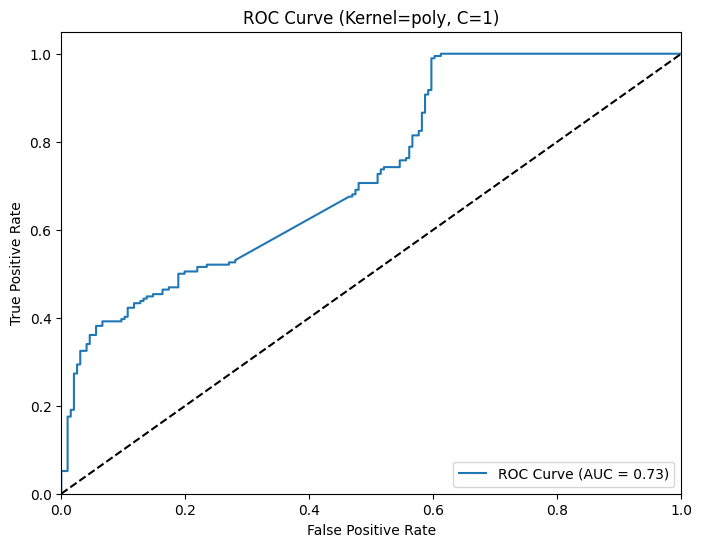

Training SVM with kernel='poly' and C=100
Model accuracy with kernel='poly' and C=100: 0.6462
Classification Report (Kernel=poly, C=100):
              precision    recall  f1-score   support

           0       0.61      0.82      0.70       196
           1       0.72      0.47      0.57       194

    accuracy                           0.65       390
   macro avg       0.67      0.65      0.63       390
weighted avg       0.67      0.65      0.63       390



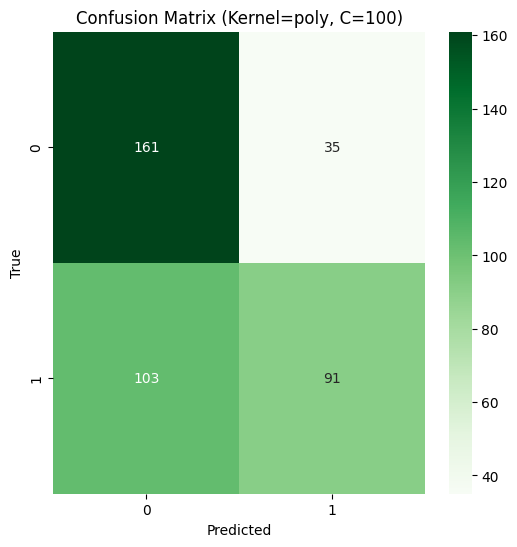

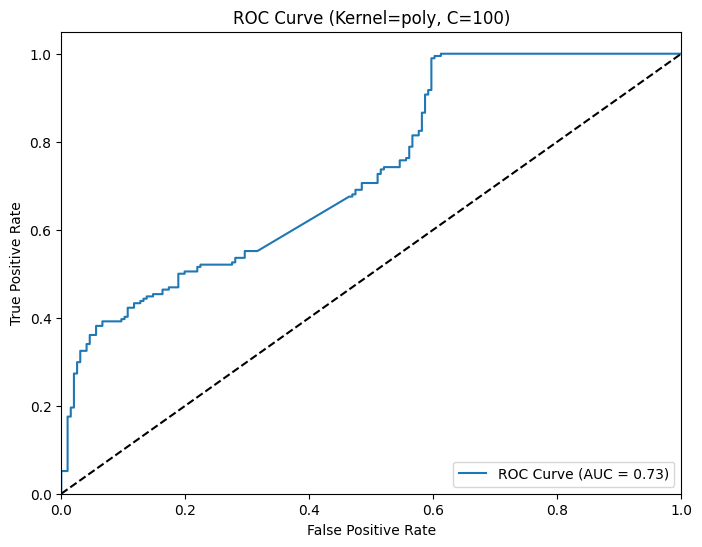

Training SVM with kernel='sigmoid' and C=1
Model accuracy with kernel='sigmoid' and C=1: 0.5205
Classification Report (Kernel=sigmoid, C=1):
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       196
           1       0.52      0.53      0.52       194

    accuracy                           0.52       390
   macro avg       0.52      0.52      0.52       390
weighted avg       0.52      0.52      0.52       390



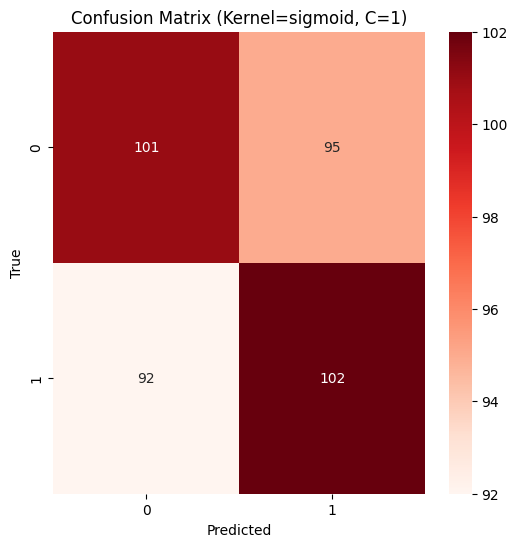

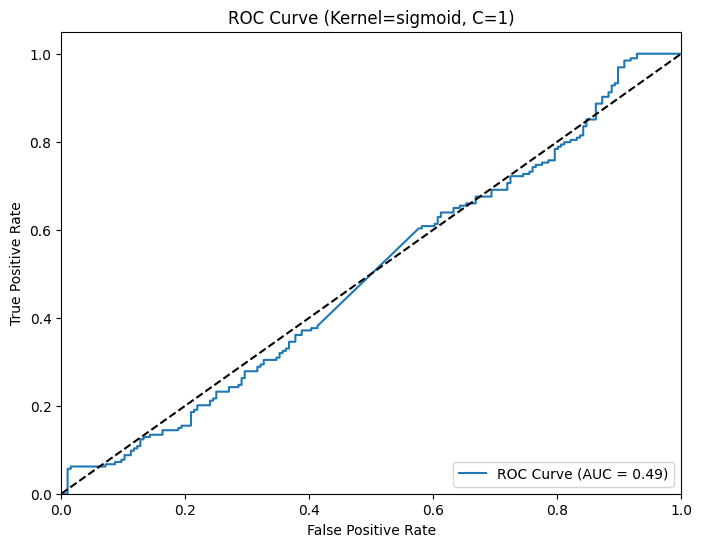

Training SVM with kernel='sigmoid' and C=100
Model accuracy with kernel='sigmoid' and C=100: 0.5128
Classification Report (Kernel=sigmoid, C=100):
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       196
           1       0.51      0.52      0.51       194

    accuracy                           0.51       390
   macro avg       0.51      0.51      0.51       390
weighted avg       0.51      0.51      0.51       390



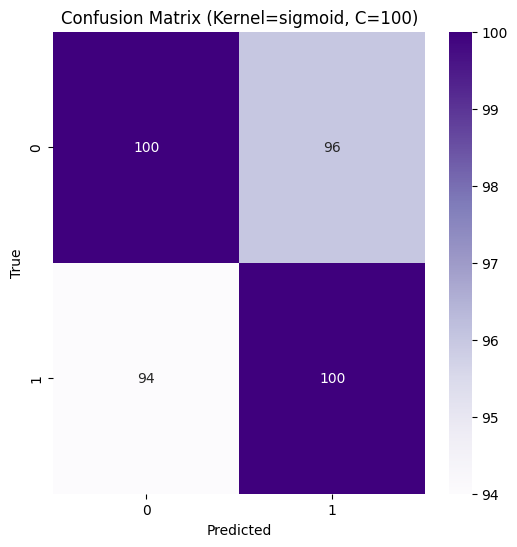

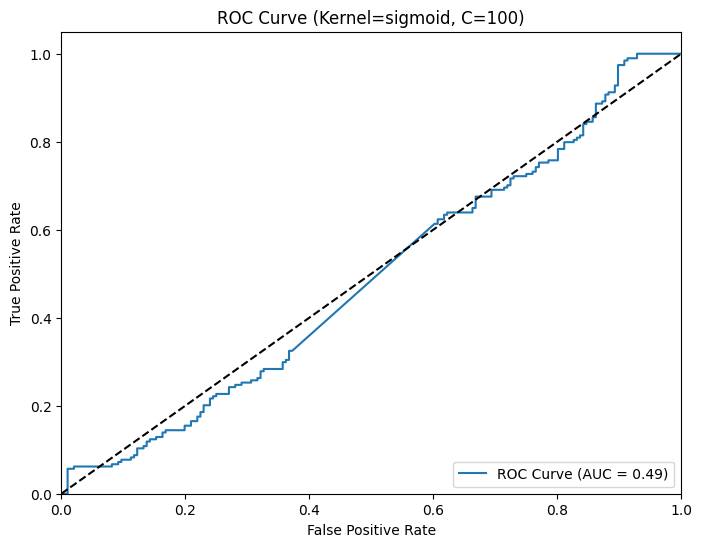

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load the final merged dataset
final_csv_path = '/content/drive/MyDrive/mimiv-iv/mimiv-iv/final_dataset.csv'
merged_df = pd.read_csv(final_csv_path)

selected_features = ['anchor_age', 'los_admission', 'hospital_expire_flag']
final_df = merged_df[selected_features]


subset_df = final_df.sample(n=1000, random_state=42)

# Separate features and target
X = subset_df.drop('hospital_expire_flag', axis=1)
y = subset_df['hospital_expire_flag']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the preprocessing for numeric features
numeric_features = ['anchor_age', 'los_admission']
numeric_transformer = StandardScaler()

preprocessor = Pipeline(steps=[
    ('num', numeric_transformer)
])

# Create the SVM pipeline
def create_svm_pipeline(kernel='rbf', C=1.0):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel=kernel, C=C, random_state=42, probability=True))
    ])

# Define different kernel types and C values
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
C_values = [1, 100]

# Dictionary to store the results
results = {'kernel': [], 'C': [], 'accuracy': [], 'confusion_matrix': [], 'roc_curve': []}

# Train and evaluate SVM models with different kernels and hyperparameters
colormaps = ['Blues', 'Greens', 'Reds', 'Purples']
for kernel in kernels:
    for C in C_values:
        print(f"Training SVM with kernel='{kernel}' and C={C}")
        svm_pipeline = create_svm_pipeline(kernel=kernel, C=C)
        svm_pipeline.fit(X_train, y_train)
        y_pred = svm_pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        y_prob = svm_pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)

        results['kernel'].append(kernel)
        results['C'].append(C)
        results['accuracy'].append(accuracy)
        results['confusion_matrix'].append(cm)
        results['roc_curve'].append((fpr, tpr, roc_auc))

        # Print the results
        print(f"Model accuracy with kernel='{kernel}' and C={C}: {accuracy:.4f}")
        print(f'Classification Report (Kernel={kernel}, C={C}):')
        print(classification_report(y_test, y_pred))

        # Plot the confusion matrix with different colormaps
        cmap = colormaps.pop(0)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix (Kernel={kernel}, C={C})')
        plt.show()
        colormaps.append(cmap)

        # Plot the ROC Curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (Kernel={kernel}, C={C})')
        plt.legend(loc='lower right')
        plt.show()


Without SMOTE
Accuracy: 0.9700
Confusion Matrix:
[[194   0]
 [  6   0]]
ROC AUC: 0.5266

With SMOTE
Accuracy: 0.7436
Confusion Matrix:
[[135  61]
 [ 39 155]]
ROC AUC: 0.8450


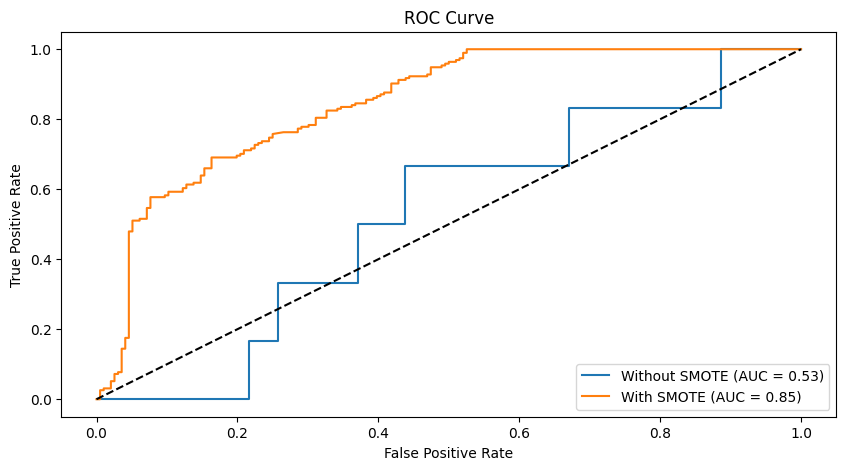

In [ ]:
# Function to train and evaluate SVM models
def train_evaluate_svm(X, y, smote=False):
    if smote:
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the preprocessing for numeric features
    numeric_features = ['anchor_age', 'los_admission']
    numeric_transformer = StandardScaler()

    preprocessor = Pipeline(steps=[
        ('num', numeric_transformer)
    ])

    # Create the SVM pipeline
    def create_svm_pipeline(kernel='rbf', C=1.0):
        return Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', SVC(kernel=kernel, C=C, random_state=42, probability=True))
        ])

    # Train and evaluate SVM with RBF kernel
    svm_pipeline = create_svm_pipeline(kernel='rbf', C=1.0)
    svm_pipeline.fit(X_train, y_train)
    y_pred = svm_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    y_prob = svm_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, cm, fpr, tpr, roc_auc

# Evaluate SVM without SMOTE
accuracy_no_smote, cm_no_smote, fpr_no_smote, tpr_no_smote, roc_auc_no_smote = train_evaluate_svm(X, y, smote=False)

# Evaluate SVM with SMOTE
accuracy_smote, cm_smote, fpr_smote, tpr_smote, roc_auc_smote = train_evaluate_svm(X, y, smote=True)

# Print results
print("Without SMOTE")
print(f"Accuracy: {accuracy_no_smote:.4f}")
print("Confusion Matrix:")
print(cm_no_smote)
print(f"ROC AUC: {roc_auc_no_smote:.4f}")

print("\nWith SMOTE")
print(f"Accuracy: {accuracy_smote:.4f}")
print("Confusion Matrix:")
print(cm_smote)
print(f"ROC AUC: {roc_auc_smote:.4f}")

# Plot ROC Curves
plt.figure(figsize=(10, 5))
plt.plot(fpr_no_smote, tpr_no_smote, label=f'Without SMOTE (AUC = {roc_auc_no_smote:.2f})')
plt.plot(fpr_smote, tpr_smote, label=f'With SMOTE (AUC = {roc_auc_smote:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
